In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, wrapper
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

## Load forcing


In [14]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

In [15]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_cafe = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cafe.zarr"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoPym_HOT_CAFE_by_epi_layer_depth"

Load forcing.


In [16]:
data = xr.open_dataset(path_to_forcing, engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data.npp.attrs["units"] = "mg/meter^2/day"
data = data.sel(time=slice(TIME_START, TIME_END))
_ = data.load()

cafe_npp = xr.open_dataset(path_to_cafe, engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [17]:
epi_layer_depth = (
    data["pelagic_layer_depth"].sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest", depth=1).load()
)
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[107.43817232572908 107.62027052217076 111.36080136467434 ... 122.58406451784043 117.06097610099505 112.42833115849288]
Units,meter


In [22]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=[LATITUDE], longitude=[LONGITUDE], layer=0, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("layer")
observations

Magnitude,[[[129.624124474013]] [[241.93912806845856]] [[226.4960632098172]] [[297.7116895188337]] [[338.10901738134515]] [[348.6248255036425]] [[414.2199940088843]] [[380.37086391164485]] [[310.5844692895031]] [[299.64035438433183]] [[286.7338147014619]] [[203.04283259024132]] [[182.27868296008955]] [[213.14200694941857]] [[158.1633054229976]] [[213.21478493739153]] [[192.8805223977997]] [[178.96047339629928]] [[192.29199430168433]] [[279.341758362888]] [[245.8340920483508]] [[251.68963730272566]] [[321.77588792557833]] [[240.68806574931386]] [[285.68678868013814]] [[135.38561638406426]] [[184.0791071674682]] [[113.49811670701962]] [[114.75327932400755]] [[291.83731297878796]] [[208.07113482962268]] [[265.3864787821936]] [[300.52656630464907]] [[405.7243406522982]] [[317.437928615958]] [[289.4888608049262]] [[369.7009236495846]] [[402.3824665716384]] [[187.91756076923684]] [[276.5028321769823]] [[168.86156637289895]] [[165.31017474498015]] [[209.021745626726]] [[153.79359005996832]] [[105.69203587027293]] [[121.46032390538892]] [[136.6561121046876]] [[277.113584643072]] [[401.3576621076453]] [[290.01453460629585]] [[295.5566502127765]] [[250.23021705519125]] [[157.99128605673212]] [[222.3851930127426]] [[49.595093611476976]] [[179.4046853090318]] [[203.90304797442036]] [[146.13778364770621]] [[416.7657754282638]] [[145.61374980536934]] [[148.209151396033]] [[377.87205094597675]] [[188.77463104603348]] [[115.03212367065039]] [[207.35448516110506]]]
Units,milligram/meter2
Magnitude,[[[311.2660641986779]] [[411.0465469177428]] [[434.4442826406097]] [[410.12685721497905]] [[425.969857918879]] [[450.2932240940246]] [[549.8204464876706]] [[601.5568938930917]] [[320.16900103833416]] [[442.9938781133052]] [[355.6783077471378]] [[300.9947590532565]] [[283.665855265022]] [[276.6976409751494]] [[298.17196146319014]] [[402.4179394274634]] [[319.8110504338187]] [[456.9291907727033]] [[346.7687266361042]] [[437.89634144384564]] [[418.5974651406048]] [[295.20449684095246]] [[388.19539164228]] [[303.20758684739826]] [[435.4124422001408]] [[362.611715698856]] [[325.90520426073266]] [[237.6615767104738]] [[197.9773516303826]] [[410.8534136867511]] [[497.50541105618447]] [[341.6488989882613]] [[547.9308357905682]] [[524.7426895856528]] [[504.88481647486975]] [[495.0607636154389]] [[573.5466988809753]] [[684.5289060294123]] [[441.30222100189826]] [[389.5605869919743]] [[295.2949918603756]] [[298.6134917508577]] [[250.80352614874343]] [[192.58467350718692]] [[236.84056030538966]] [[230.71882779833012]] [[296.7859270243095]] [[409.62286737762616]] [[494.6507934657993]] [[410.0118698216234]] [[324.2049046254114]] [[331.8167208270913]] [[479.1847605422972]] [[470.81495020759496]] [[147.9058251957733]] [[222.62600796122507]] [[253.23644167716574]] [[265.4001639994968]] [[591.1972202501328]] [[294.84398967274774]] [[541.8992206865995]] [[443.7821789140124]] [[269.0953953843323]] [[293.67534101178416]] [[306.4898277443372]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [24]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2025-01-14 17:43:10,993 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



In [25]:
parameterization = [
    [1, 1, 0.1668, 10.38, -0.11, 150, 0.15],
]

## Run simulation


In [26]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=parameterization, groups_name=["D1N1"]),
)

model_print.run()

In [27]:
model_print.state

<xarray.Dataset> Size: 182kB
Dimensions:                       (functional_group: 1, depth: 3, latitude: 1,
                                   longitude: 1, time: 1827, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * depth                         (depth) int32 12B 1 2 3
  * latitude                      (latitude) float64 8B 22.75
  * longitude                     (longitude) int64 8B -158
  * time                          (time) datetime64[ns] 15kB 2005-01-01 ... 2...
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/28)
    name                          (functional_group) <U4 16B 'D1N1'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    min_temperature               (functional_group, cohort) float64 88B 21.2...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 20kB ...
    cell_area                     (latitude, longitude) float64 8B 7.918e+07
    mortality_field               (functional_group, time, latitude, longitude) float64 15kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 15kB ...
    biomass                       (functional_group, time, latitude, longitude) float64 15kB ...

## Plot


In [28]:
biomass = model_print.export_biomass().pint.quantify().pint.to("mg/meter^2")
layer_depth = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")
observations = observations.pint.quantify().pint.to("mg/meter^2")

### Taylor Diagram


In [29]:
biomass_pandas = biomass.pint.dequantify().to_dataframe().reset_index().set_index("time")["biomass"]
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [30]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass (CAFE npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [31]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.5099267641194015, 0.4507823640535488]
norm STD [0.5003845932931347, 0.3964237714406932]
bias [0.7481894193464954, -0.681238878206601]
NRMSE [0.8602707412546319, 0.894287491162179]
name ['HOT Day', 'HOT Night']


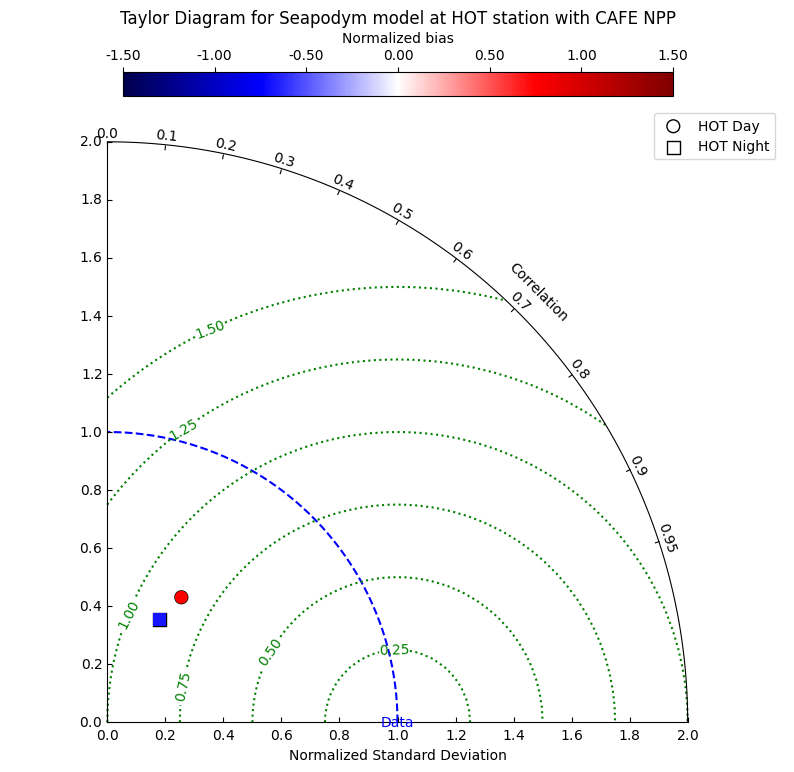

In [32]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred, monthly_pred]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model at HOT station with CAFE NPP")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [33]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.509927,0.500385,0.748189,0.860271
1,HOT Night,0.450782,0.396424,-0.681239,0.894287
